## Install dependency if in colab environment. Not required for local execution.

In [1]:
import sys

if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    !pip install torch==2.4.0
    !pip install torch_geometric
else:
    print("Not running in Google Colab")
    # For mac, this has to be set once to enable multiprocessing dataloader.
    import multiprocessing
    try:
        multiprocessing.set_start_method("fork")
    except RuntimeError:
        print(f"Context has alrady been set: {multiprocessing.get_start_method()}")
    assert multiprocessing.get_start_method() == "fork"

import zipfile
import os
from tqdm import tqdm
import torch
from torch_geometric.data import Data, Dataset, download_url
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from functools import lru_cache
from math import floor
import mmap
import numpy as np
import random
from typing import List, Tuple

Not running in Google Colab


## Download simulated autonomous vehicle data

In [2]:
FEATURE_DIMENSION = 9
TIMESTAMP_FEATURE_INDEX = 3
HEALTHY_NODE_LABEL = 0
ROOT_CAUSE_NODE_LABEL = 1

class GraphFaultInjectionDataset(Dataset):
  """

  Args:
      root: Root directory where the dataset should be saved.
      device: Device to use. Must be "cuda" or "mps".
      batch_size: Batch size to use.
      force_reload: If set to ``True``, the dataset will be re-downloaded and reprocessed.
  """
  def __init__(self, root: str,  device: str, batch_size: int,force_reload: bool = False):
    assert device != "cpu", "CPU ain't gonna cut it"
    self.train_file_idx = []
    self.test_file_idx = []
    self.raw_data_paths = []
    self.file_idx_to_graph_idx_range = []
    self.total_num_graphs = 0
    self.device = device
    self.batch_size = batch_size
    super().__init__(root=root, force_reload=force_reload)

  #####################################
  # PyG Dataset interface
  #####################################
  # Download entire dataset folder and unzip it into raw_dir.
  def download(self):
    SOURCE_URL = "https://github.com/yundddd/graph_generator/raw/master/graph_generator/dataset/autonomous_vehicle.zip"
    zip_path = download_url(url=SOURCE_URL, folder=self.raw_dir)
    self._unzip_file(zip_path, self.raw_dir)

  # If the raw zip exist, skip download unless force_reload is passed to the constructor.
  @property
  def raw_file_names(self):
      return ["autonomous_vehicle.zip"]
  
  # Always process.
  @property
  def processed_file_names(self):
      return ["always_process.pt"]

  def process(self):
    for subfolder in list(os.listdir(os.path.join(self.raw_dir, "autonomous_vehicle/"))):
      print("processing subfolder", subfolder)
      subfolder_path = os.path.join(self.raw_dir, "autonomous_vehicle/", subfolder)
      edge_idx_path = os.path.join(subfolder_path, 'edge_index.csv')
      
      subfolder_raw_files = []

      for file_name in os.listdir(subfolder_path):
        if 'inject' in file_name:
          injection_time = self._get_injection_time(file_name)
          node_features_path = os.path.join(subfolder_path, f'node_feature_inject_at_{injection_time}.csv')
          fault_label_path = os.path.join(subfolder_path, f'fault_label_inject_at_{injection_time}.csv')
          subfolder_raw_files.append((node_features_path, fault_label_path, edge_idx_path))
      
      print(f"collected {len(subfolder_raw_files)} fault injection sweeps from subfolder {subfolder}")

      for node_feature_file, _, _ in subfolder_raw_files:
        num_graph = self._count_graphs(node_feature_file)
        self.file_idx_to_graph_idx_range.append((self.total_num_graphs, self.total_num_graphs + num_graph - 1))
        self.total_num_graphs += num_graph

      self.raw_data_paths += subfolder_raw_files
      ## construct train/test masks.
      train_file_idx, test_file_idx = self._sample_train_test_file_masks(len(subfolder_raw_files), split=0.8)
      train_length = len(train_file_idx)
      test_length = len(test_file_idx)
      self.train_file_idx += [idx + train_length for idx in train_file_idx]
      self.test_file_idx += [idx + test_length for idx in test_file_idx]

    if self.force_reload or self._should_write_tensor_to_disk():
      # saving node_feature tensors
      with tqdm(total=len(self.raw_data_paths), desc=f"Saving feature tensors to disk", unit="files") as pbar:
        for idx in range(len(self.raw_data_paths)):
          node_feature, fault_label = self._node_feature_and_label_to_tensor(self.raw_data_paths[idx][0], self.raw_data_paths[idx][1])
          torch.save(node_feature, os.path.join(self.processed_dir, f'node_feature_{idx}.pt'))
          torch.save(fault_label, os.path.join(self.processed_dir, f'fault_label_{idx}.pt'))
          pbar.update(1)
      
    print(f"total number of graphs: {self.total_num_graphs}")
    print(f"total number of raw files: {len(self.raw_data_paths)}")

  def len(self):
    return self.total_num_graphs
  
  def get(self, idx):
    graph_offset_in_file = idx - self.file_idx_to_graph_idx_range[self._graph_idx_to_file_idx(idx)][0]
    file_idx = self._graph_idx_to_file_idx(idx)

    node_feature, fault_label = self._load_feature_and_label(file_idx)
    data = Data(x=node_feature[graph_offset_in_file], y=fault_label[graph_offset_in_file], edge_index=self.edge_index)
    return data


  #####################################
  # Helpers
  #####################################
  
  # Get a dataloader for training.
  def train_loader(self):
    loader = DataLoader(Subset(self, self.train_idx), batch_size=self.batch_size, shuffle=False, num_workers=2, prefetch_factor=2)
    return preload_to_gpu(loader, self.device)
  
  # Get a dataloader for testing.
  def test_loader(self):
    loader = DataLoader(Subset(self, self.test_idx), batch_size=self.batch_size, shuffle=False, num_workers=2, prefetch_factor=2)
    return preload_to_gpu(loader, self.device)
  
  # Helper to get train file mask
  @property  
  def train_idx(self):
    result = []
    for file_idx in self.train_file_idx:
        result.extend(self._file_idx_to_graph_idx(file_idx))
    return result
  
  # Helper to get test file mask
  @property  
  def test_idx(self):
    result = []
    for file_idx in self.test_file_idx:
        result.extend(self._file_idx_to_graph_idx(file_idx))
    return result
  
  # only read edge index from file once since graph structure doesn't change.
  @property
  @lru_cache(maxsize=32)
  def edge_index(self):
    return self._get_edge_index(self.raw_data_paths[0][2])
  
  # If the procssed tensor is not on disk, write all tensor to disk.
  def _should_write_tensor_to_disk(self):
    return not os.path.exists(self.processed_dir + "/node_feature_0.pt")

  # Load feature and label tensors from disk. Cache the result to reduce file IO.
  @lru_cache(maxsize=32)
  def _load_feature_and_label(self, idx):
    return (torch.load(os.path.join(self.processed_dir, f'node_feature_{idx}.pt'), weights_only=True, mmap=True),
           torch.load(os.path.join(self.processed_dir, f'fault_label_{idx}.pt'), weights_only=True, mmap=True))
  
  # Each file contains multiple graphs. We need to map a graph index to a file index and vice versa.
  def _file_idx_to_graph_idx(self, file_idx):
    r = self.file_idx_to_graph_idx_range[file_idx]
    return range(r[0], r[1] + 1)
    
  def _graph_idx_to_file_idx(self, graph_idx):
    def find_range_index(ranges, target_range):
      return next((i for i, r in enumerate(ranges) if r[0] <= target_range and r[1] >= target_range), -1)
    return find_range_index(self.file_idx_to_graph_idx_range, graph_idx)

  # Sample train/test file masks evenly for each fault.
  def _sample_train_test_file_masks(self, data_length: int, split: float = 0.8) -> Tuple[List[int], List[int]]:
    train_idx = sorted(random.sample(range(data_length), floor(data_length * split)))
    val_idx = sorted(list(set(range(data_length)) - set(train_idx)))
    return train_idx, val_idx

  # Count the number of graphs from a feature file.
  def _count_graphs(self, file_path):
    with open(file_path, 'r') as f:
        # Memory-map the file (0 means the entire file)
        mmapped_file = mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)
        
        # Count occurrences of newline characters (\n)
        line_count = 0
        while True:
            byte = mmapped_file.readline()
            if not byte:
                break
            line_count += 1
        return line_count

  def _get_edge_index(self, path):
      edges = []
      with open(path, "r") as output:
        i = 0
        for line in output:
          edge = line.strip().split(',')
          edges.append([int(edge[0]), int(edge[1])])
      return torch.tensor(edges, dtype=torch.long).t().contiguous() # put edges into COO format

  def _get_node_at_fault(self, path):
    node_at_fault, timestamp_of_fault = 0, 0
    with open(path, "r") as output:
      ind = 0
      for line in output:
        node_at_fault, timestamp_of_fault = line.strip().split(',')
        ind += 1
      assert ind == 1 # there should only be one line in this file
    return int(node_at_fault), int(timestamp_of_fault)
  
  def _get_injection_time(self, file_name: str):
    return file_name.split('_')[-1].split('.')[0]

  # Read raw feature and label files from disk and then compute the tensors.
  @lru_cache(maxsize=32)
  def _node_feature_and_label_to_tensor(self, node_features_path, fault_label_path) -> Tuple[torch.Tensor, torch.Tensor]:
    node_features, node_labels = [], []
    node_at_fault, timestamp_of_fault = self._get_node_at_fault(fault_label_path)
    with open(node_features_path, "r") as output:
      with mmap.mmap(output.fileno(), length=0, access=mmap.ACCESS_READ) as mm:
        for line in iter(mm.readline, b""):  # Read lines from mmap:
          line = line.decode('utf-8').strip()
          items = line.strip().split(',')
          features = [list(map(int, items[i + 1 : i + FEATURE_DIMENSION + 1]))
                            for i in range(0, len(items), FEATURE_DIMENSION + 1)]
          time = max([node[TIMESTAMP_FEATURE_INDEX] for node in features])
          node_features.append(features)
          labels = [HEALTHY_NODE_LABEL] * len(features)
          if time >= timestamp_of_fault:
            labels[node_at_fault] = ROOT_CAUSE_NODE_LABEL
          node_labels.append(labels)

    node_labels = torch.tensor(node_labels, dtype=torch.long)
    node_features = torch.tensor(node_features, dtype=torch.float)
    # TODO: use sparse tensor
    #indices = torch.nonzero(node_labels, as_tuple=False).t()
    #values = node_labels[indices[0]]
    #sparse_label = torch.sparse_coo_tensor(indices, values, node_labels.size())
    return node_features, node_labels
            
  def _unzip_file(self,zip_path: str, extract_to :str) -> None:
    print("unzipping")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Unzipped to '{extract_to}'")
    
# A helper to preload the data to GPU. This can significantly speed up training.
def preload_to_gpu(loader, device):
    out = []
    with tqdm(total=len(loader), desc=f"Preloading data to GPU", unit="batch") as pbar:
        for batch in loader:
            try:
                batch = batch.to(device)
            except Exception as e:
                assert False, f"GPU memory is full. Please restart kernel. Error: {e}"
            out.append(batch)
            pbar.update(1)
    return DataLoader(out, shuffle=False)
  
def print_gpu_usage(device):
    if device == "cuda":
        print(f"GPU memory usage: {torch.cuda.memory_allocated(device) / 1024**3} GB / {torch.cuda.get_device_properties(device).total_memory / 1024**3} GB")
    elif device == "mps":
         # Total memory allocated by tensors on MPS
        allocated_memory = torch.mps.current_allocated_memory()
        print(f"Allocated memory: {allocated_memory / 1024**2:.2f} MB")
        
        # Total memory reserved by PyTorch for MPS
        reserved_memory = torch.mps.driver_allocated_memory()
        print(f"Reserved memory: {reserved_memory / 1024**2:.2f} MB")

In [3]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    device = "mps"
    torch.mps.empty_cache()
else:
    assert False, "No GPU detected"

print(f"using device: {device}")
print_gpu_usage(device)

my_dataset = GraphFaultInjectionDataset(root="/tmp", batch_size=4096, device=device, force_reload=False)

train_loader = my_dataset.train_loader()
test_loader = my_dataset.test_loader()
print_gpu_usage(device)


using device: cuda
GPU memory usage: 0.0 GB / 11.9935302734375 GB
processing subfolder crash_tracker
collected 80 fault injection sweeps from subfolder crash_tracker
processing subfolder drop_raw_camera1_publish
collected 80 fault injection sweeps from subfolder drop_raw_camera1_publish


Processing...


processing subfolder drop_raw_camera1_receive
collected 80 fault injection sweeps from subfolder drop_raw_camera1_receive
processing subfolder mutate_raw_camera1_publish
collected 80 fault injection sweeps from subfolder mutate_raw_camera1_publish
processing subfolder crash_camera_driver1
collected 80 fault injection sweeps from subfolder crash_camera_driver1
total number of graphs: 3688548
total number of raw files: 400


Done!
Preloading data to GPU: 100%|███████████████████████████████████████████████████████████████████| 175/175 [00:19<00:00,  9.06batch/s]

GPU memory usage: 7.46173095703125 GB / 11.9935302734375 GB


## Model

In [4]:
import torch.nn.functional as F
from torch_geometric.nn import (
    SAGEConv,
    GCNConv,
    GATConv,
)
class DirectedGCN(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes):
        super().__init__()
        self.conv1 = GCNConv(input_features, hidden_dim, improved=True)  #improved option for directed graphs
        self.conv2 = GCNConv(hidden_dim, output_classes, improved=True)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
class DirectedGraphSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes):
        super().__init__()
        self.preprocessing1 = torch.nn.Linear(input_features, input_features * 2)
        self.preprocessing2 = torch.nn.Linear(input_features * 2, hidden_dim)
        self.conv1 = SAGEConv(hidden_dim, hidden_dim, normalize=True)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim, normalize=True)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.post_processing = torch.nn.Parameter(torch.randn(hidden_dim, output_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.preprocessing1(x)
        x = self.preprocessing2(x)
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = torch.matmul(x, self.post_processing)
        return F.log_softmax(x, dim=1)
    
class DirectedGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_dim, output_classes, heads=4):
        super().__init__()
        self.preprocessing1 = torch.nn.Linear(input_features, input_features * 2)
        self.preprocessing2 = torch.nn.Linear(input_features * 2, hidden_dim)
        self.conv1 = GATConv(hidden_dim, hidden_dim, heads=heads, concat=True)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=False)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.post_processing = torch.nn.Parameter(torch.randn(hidden_dim, output_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.preprocessing1(x)
        x = self.preprocessing2(x)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = torch.matmul(x, self.post_processing)
        return F.log_softmax(x, dim=1)

## config

In [5]:
input_features = FEATURE_DIMENSION
hidden_dim = input_features * 4
output_classes = 2

MODELS = {
    'DirectedGCN': DirectedGCN,
    'DirectedGraphSAGE': DirectedGraphSAGE,
    'DirectedGAT': DirectedGAT,
    #'GRNN': GRNN
}

## Training

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output



def build_model(model_name, input_features, hidden_dim, output_classes):
    model = MODELS[model_name](input_features, hidden_dim, output_classes)
    return model, model_name

def train(model, train_loader, test_loader, num_epoch, lr=0.00001, weight_decay=5e-4, loss_function=F.nll_loss):
    plt.figure()

    train_losses = []
    test_losses = []
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    print(f"Training {num_epoch} epochs with {len(train_loader)} batches each")
    for epoch in range(num_epoch):
        model.train()
        train_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Train Epoch {epoch+1}/{num_epoch}", unit="batch") as pbar:
            for batch in train_loader:
                pbar.update(1)
                
                optimizer.zero_grad()
                out = model(batch)
                loss = loss_function(out, batch.y)

                loss.backward()
                train_loss += loss.item()

                optimizer.step()
                
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        test_loss = 0.0
        
        with tqdm(total=len(test_loader), desc=f"Testing", unit="batch") as pbar:
            with torch.no_grad():
                for batch in test_loader:
                    pbar.update(1)
                    out = model(batch)
                    loss = loss_function(out, batch.y)
                    test_loss += loss.item()

        test_losses.append(test_loss / len(test_loader))
        

        # Clear the plot before updating
        plt.clf()  # Clear the figure to avoid accumulating legends and line
        clear_output(wait=True)
        # Update the plot dynamically
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(test_losses, label='Test Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.grid(alpha=0.3)  # Optional: add a grid
        plt.show()
plt.close()


def evaluate(model, model_name, loader, plt_confusion_matrix = True):
    classification_threshold, host_targets, host_raw_probs = find_best_threshold(model, loader)
    host_preds = (host_raw_probs > classification_threshold).long()
    report = classification_report(host_targets, host_preds, digits=4, zero_division=0)
    
    print(f'Model: {model_name}')
    print(report)

    if plt_confusion_matrix:
      generate_cm(host_targets, host_preds, model_name)

def find_best_threshold(model, loader):
    model.eval()
    targets = []
    raw_probs = []

    with torch.no_grad():
        with tqdm(total=len(loader), desc=f"Finding the best classification threshold", unit="batch") as pbar:
            for batch in loader:
                out = model(batch)
                raw_prob = torch.exp(out[:,1]) # Get class 1 predictions and convert to probability.
                raw_probs.append(raw_prob)
                
                targets.append(batch.y)
                pbar.update(1)

    targets = torch.cat(targets)
    raw_probs = torch.cat(raw_probs)
    
    host_targets = targets.to('cpu')
    host_raw_probs = raw_probs.to('cpu')
    
    fpr, tpr, thresholds = roc_curve(host_targets, host_raw_probs)
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    best_idx = np.argmin(distances)
    best_threshold = thresholds[best_idx]
    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"True Positive Rate: {tpr[best_idx]:.4f}, False Positive Rate: {fpr[best_idx]:.4f}")   

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold: {best_threshold:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()
    
    return best_threshold, host_targets, host_raw_probs

def generate_cm(y_true, y_pred, model_name):
  cm = confusion_matrix(y_true, y_pred)

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'{model_name} Confusion Matrix')
  plt.show()

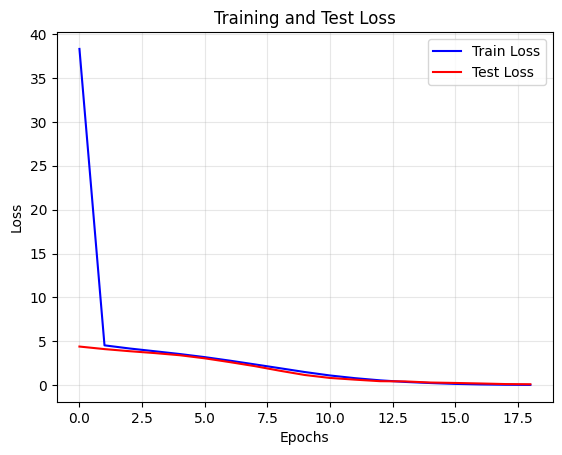

Train Epoch 20/100:   4%|███                                                                     | 31/723 [00:00<00:14, 47.10batch/s]


KeyboardInterrupt: 

In [17]:
model, model_name = build_model("DirectedGAT", input_features, hidden_dim, output_classes)
train(model, train_loader, test_loader, 100)


Finding the best classification threshold: 100%|████████████████████████████████████████████████| 175/175 [00:01<00:00, 98.31batch/s]


Best Threshold: 0.0031
True Positive Rate: 0.9841, False Positive Rate: 0.0461


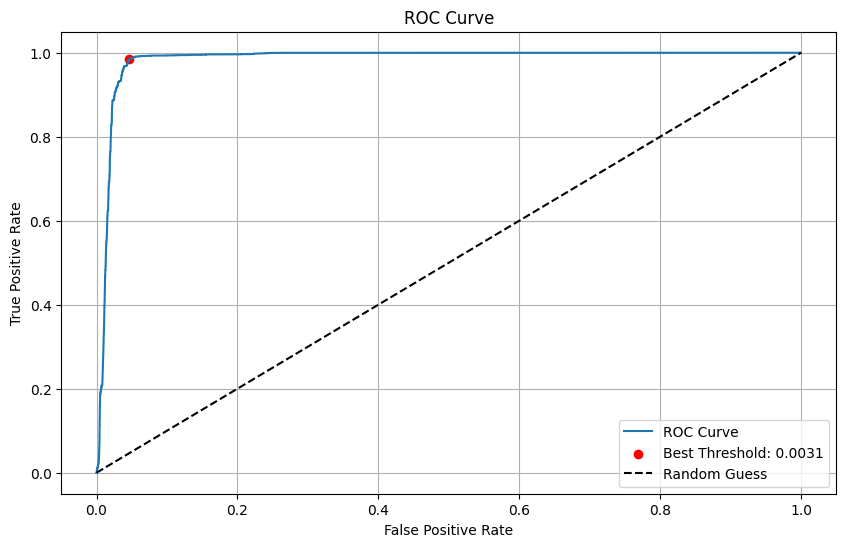

Model: DirectedGAT
              precision    recall  f1-score   support

           0     0.9998    0.9539    0.9763  20537237
           1     0.1897    0.9841    0.3181    225110

    accuracy                         0.9543  20762347
   macro avg     0.5948    0.9690    0.6472  20762347
weighted avg     0.9910    0.9543    0.9692  20762347



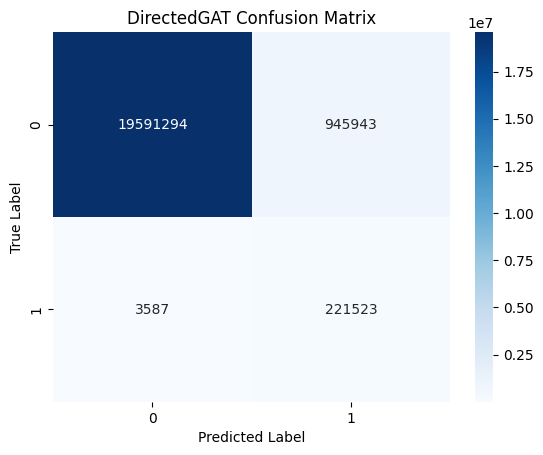

In [18]:
evaluate(model, model_name, test_loader)